In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data.csv')

In [9]:
data.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

#### Data Cleaning

In [11]:
data = data.drop(columns=['Unnamed: 32', 'id'])


In [12]:
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})


#### Exploratory Data Analysis

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


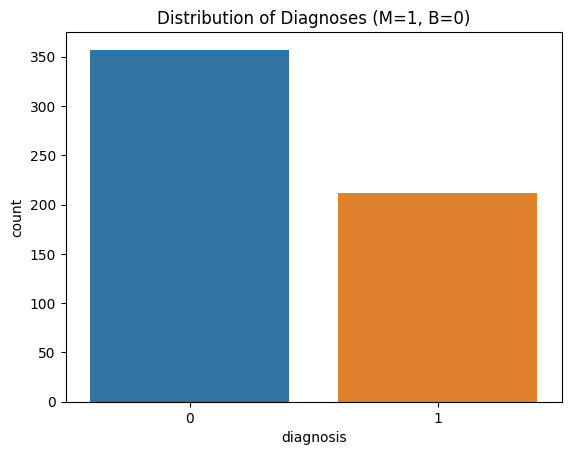

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of the distribution of diagnosis
sns.countplot(data['diagnosis'])
plt.title('Distribution of Diagnoses (M=1, B=0)')
plt.show()



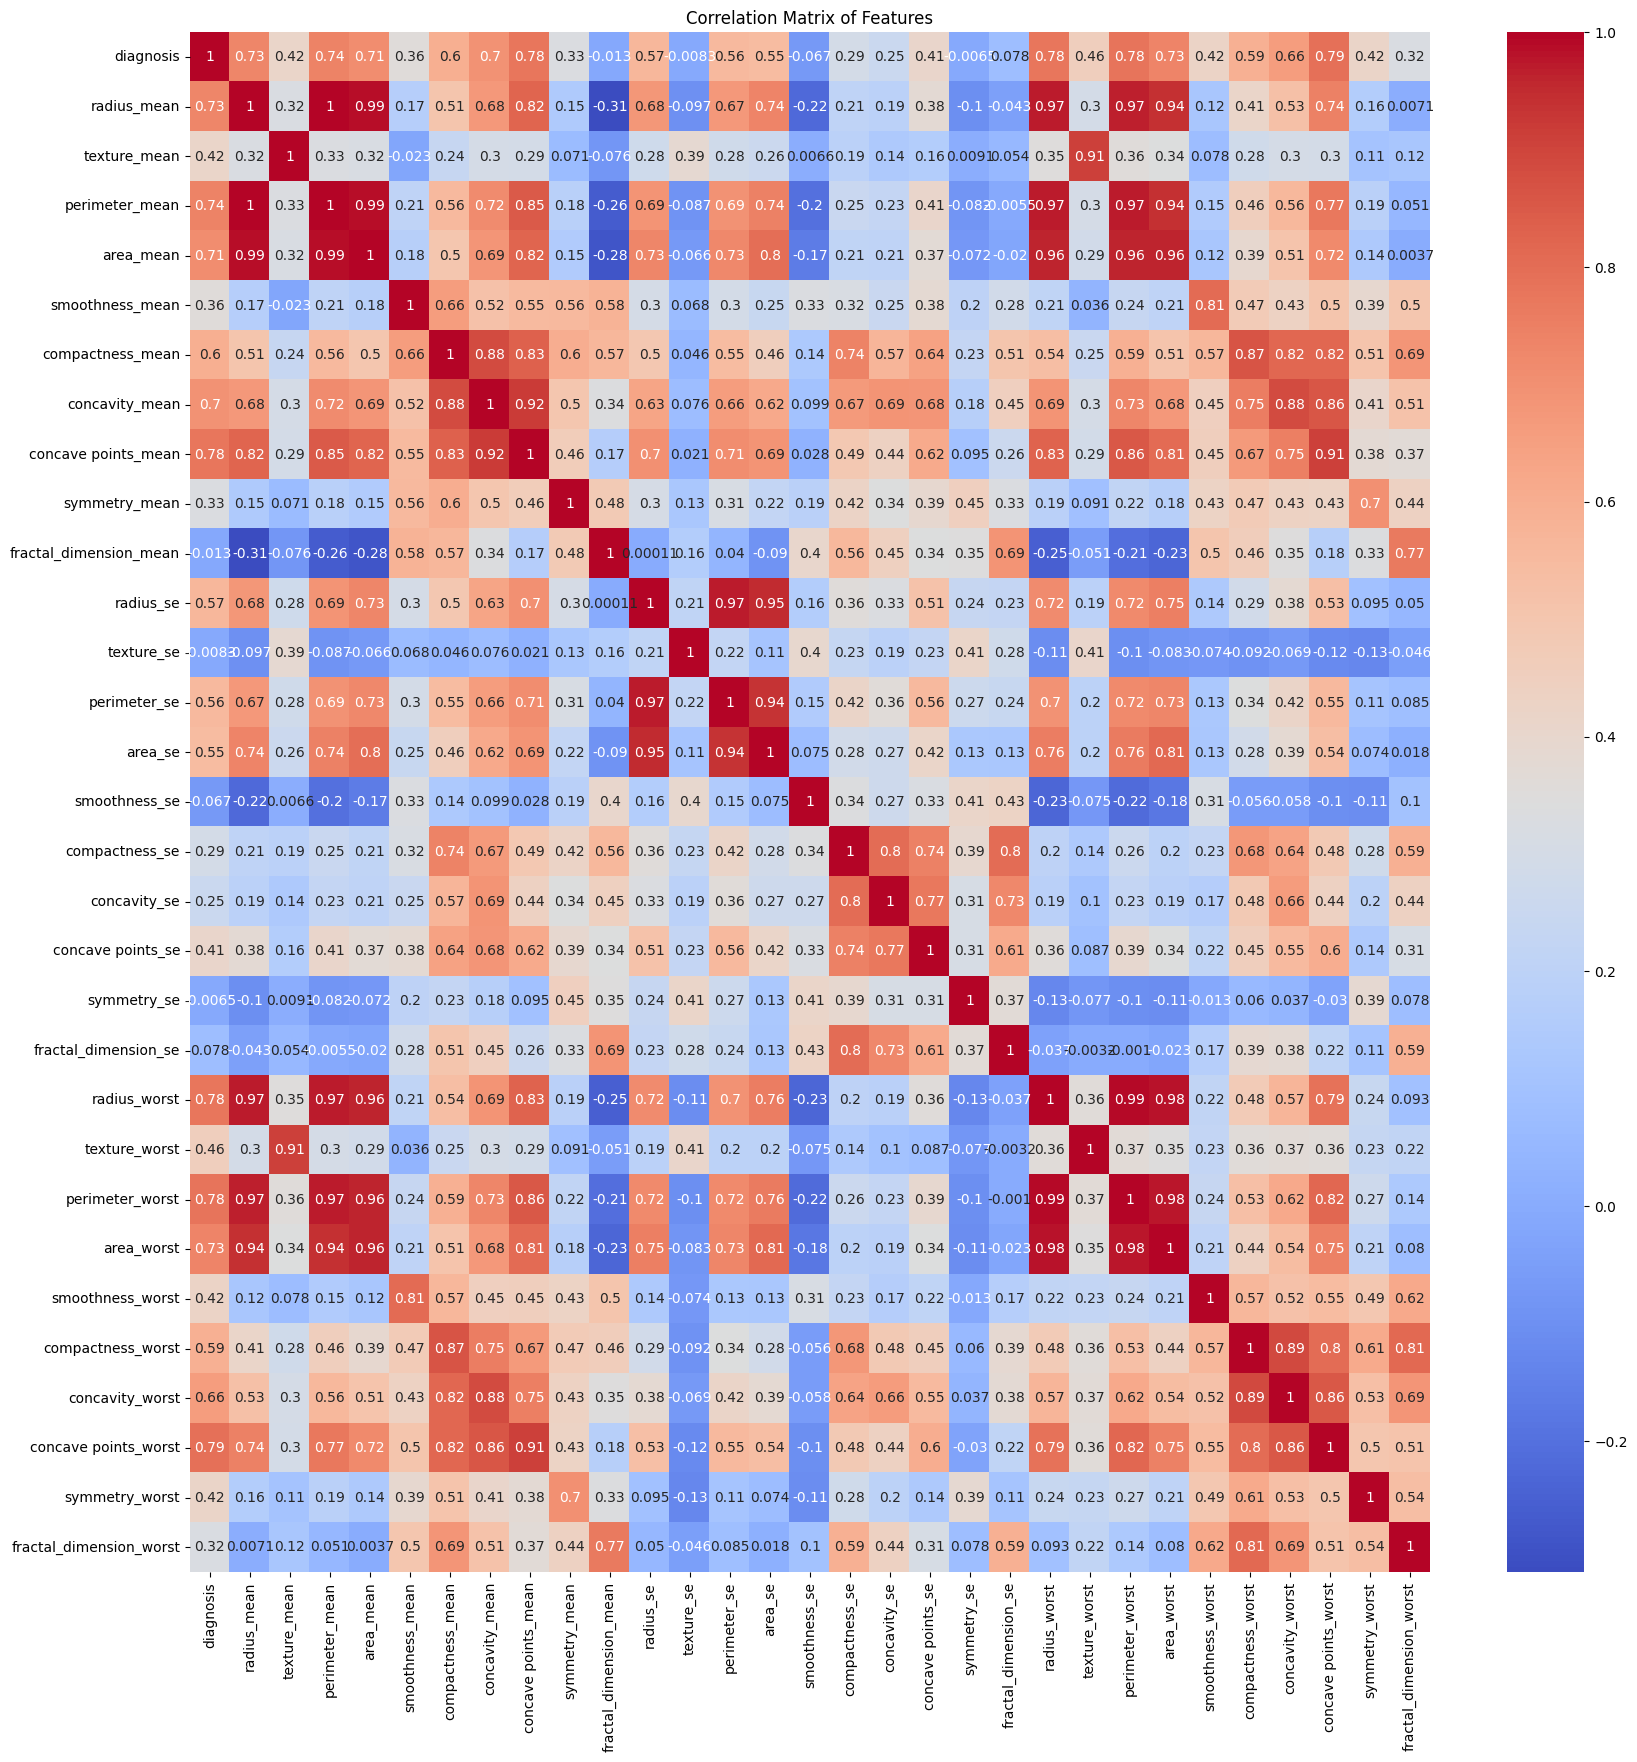

In [22]:

# Visualization of correlation between features
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

#

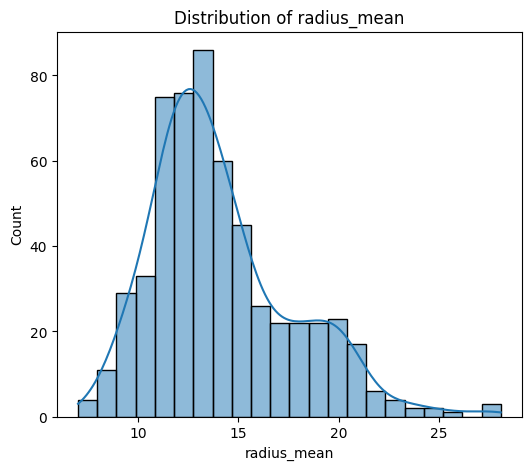

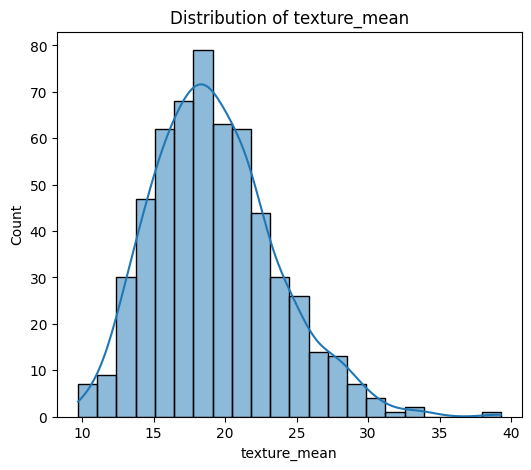

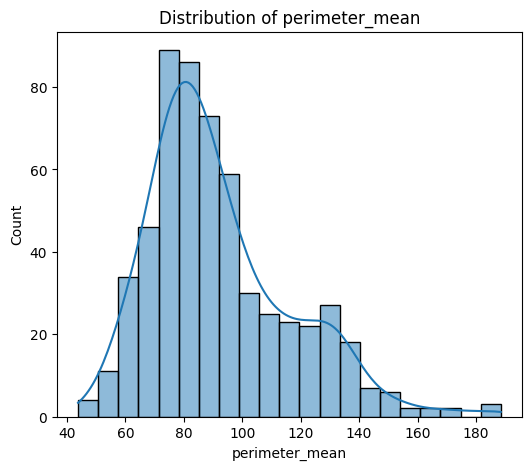

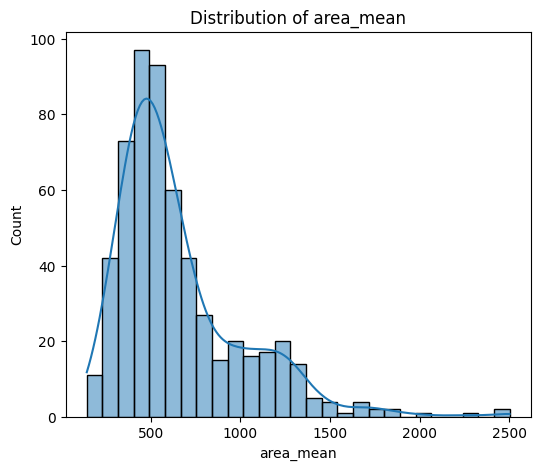

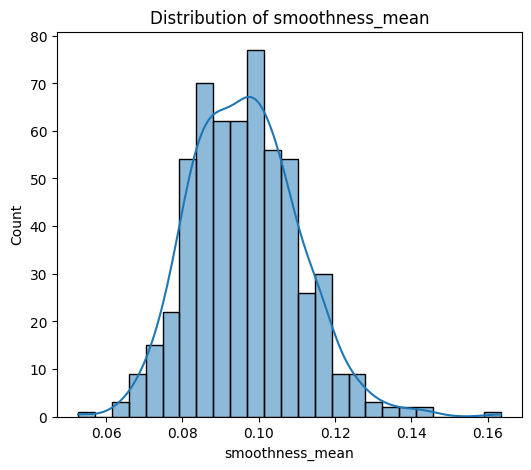

In [23]:

# Visualization of the distribution of some features
features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']
for feature in features:
    plt.figure(figsize=(6, 5))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

#### Data Processing, Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['diagnosis'])
y = data['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Standardize the data (mean=0 and variance=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to the training data to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)




### Modelling and Training

In [25]:
from sklearn.svm import SVC

# List of SVMs
svms = [
    SVC(kernel='linear', probability=True),
    SVC(kernel='poly', degree=3, probability=True),
    SVC(kernel='rbf', probability=True),
    SVC(kernel='sigmoid', probability=True)
]


In [26]:
for svm in svms:
    svm.fit(X_train_balanced, y_train_balanced)


In [27]:
from scipy.stats import mode

predictions = []

for svm in svms:
    predictions.append(svm.predict(X_test))

# Majority voting
final_predictions = mode(predictions, axis=0)[0][0]


/var/folders/k_/9x515wpn05v792xf_7psj65w0000gn/T/ipykernel_2938/3295708405.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_predictions = mode(predictions, axis=0)[0][0]


In [28]:
probs = []

for svm in svms:
    probs.append(svm.predict_proba(X_test)[:, 1])  # get probabilities for class '1'

# Averaging
avg_probs = sum(probs) / len(svms)
avg_predictions = [1 if prob > 0.5 else 0 for prob in avg_probs]


### Evaluation

In [29]:
from sklearn.metrics import accuracy_score

# For voting-based ensemble
accuracy_voting = accuracy_score(y_test, final_predictions)

# For averaging-based ensemble
accuracy_avg = accuracy_score(y_test, avg_predictions)

print(f"Voting-based Ensemble Accuracy: {accuracy_voting}")
print(f"Averaging-based Ensemble Accuracy: {accuracy_avg}")


Voting-based Ensemble Accuracy: 0.9883040935672515
Averaging-based Ensemble Accuracy: 0.9824561403508771


In [30]:
single_svm = SVC(kernel='linear')
single_svm.fit(X_train_balanced, y_train_balanced)
single_predictions = single_svm.predict(X_test)
accuracy_single = accuracy_score(y_test, single_predictions)

print(f"Single SVM Accuracy: {accuracy_single}")


Single SVM Accuracy: 0.9766081871345029


#### HyperParameter Tuning

In [34]:
from sklearn.model_selection import GridSearchCV

# Defining the grid of parameters
param_grid = {
    'C': [0.0001,0.001, 0.1, 1, 10, 100, 1000],
    'gamma': [1000,100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid_search.fit(X_train_balanced, y_train_balanced)
best_params = grid_search.best_params_

single_svm_optimized = SVC(**best_params)
single_svm_optimized.fit(X_train_balanced, y_train_balanced)
single_predictions_optimized = single_svm_optimized.predict(X_test)
accuracy_single_optimized = accuracy_score(y_test, single_predictions_optimized)

print(f"Optimized Single SVM Accuracy: {accuracy_single_optimized}")


Fitting 5 folds for each of 126 candidates, totalling 630 fits
[CV 1/5] END C=0.0001, gamma=1000, kernel=linear;, score=0.690 total time=   0.0s
[CV 2/5] END C=0.0001, gamma=1000, kernel=linear;, score=0.710 total time=   0.0s
[CV 3/5] END C=0.0001, gamma=1000, kernel=linear;, score=0.780 total time=   0.0s
[CV 4/5] END C=0.0001, gamma=1000, kernel=linear;, score=0.747 total time=   0.0s
[CV 5/5] END C=0.0001, gamma=1000, kernel=linear;, score=0.677 total time=   0.0s
[CV 1/5] END ..C=0.0001, gamma=1000, kernel=rbf;, score=0.510 total time=   0.0s
[CV 2/5] END ..C=0.0001, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 3/5] END ..C=0.0001, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END ..C=0.0001, gamma=1000, kernel=rbf;, score=0.495 total time=   0.0s
[CV 5/5] END ..C=0.0001, gamma=1000, kernel=rbf;, score=0.495 total time=   0.0s
[CV 1/5] END C=0.0001, gamma=100, kernel=linear;, score=0.690 total time=   0.0s
[CV 2/5] END C=0.0001, gamma=100, kernel=

[CV 2/5] END .....C=0.001, gamma=10, kernel=rbf;, score=0.560 total time=   0.0s
[CV 3/5] END .....C=0.001, gamma=10, kernel=rbf;, score=0.540 total time=   0.0s
[CV 4/5] END .....C=0.001, gamma=10, kernel=rbf;, score=0.495 total time=   0.0s
[CV 5/5] END .....C=0.001, gamma=10, kernel=rbf;, score=0.495 total time=   0.1s
[CV 1/5] END ...C=0.001, gamma=1, kernel=linear;, score=0.930 total time=   0.0s
[CV 2/5] END ...C=0.001, gamma=1, kernel=linear;, score=0.950 total time=   0.0s
[CV 3/5] END ...C=0.001, gamma=1, kernel=linear;, score=0.930 total time=   0.0s
[CV 4/5] END ...C=0.001, gamma=1, kernel=linear;, score=0.919 total time=   0.0s
[CV 5/5] END ...C=0.001, gamma=1, kernel=linear;, score=0.949 total time=   0.0s
[CV 1/5] END ......C=0.001, gamma=1, kernel=rbf;, score=0.610 total time=   0.0s
[CV 2/5] END ......C=0.001, gamma=1, kernel=rbf;, score=0.650 total time=   0.0s
[CV 3/5] END ......C=0.001, gamma=1, kernel=rbf;, score=0.630 total time=   0.0s
[CV 4/5] END ......C=0.001, 

[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.919 total time=   0.0s
[CV 1/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.960 total time=   0.0s
[CV 2/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.990 total time=   0.0s
[CV 3/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.980 total time=   0.0s
[CV 4/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=1.000 total time=   0.0s
[CV 5/5] END ..C=0.1, gamma=0.01, kernel=linear;, score=0.980 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.920 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.960 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.910 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.949 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.949 total time=   0.0s
[CV 1/5] END .C=0.1, gamma=0.001, kernel=linear;, score=0.960 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=0

[CV 2/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.910 total time=   0.0s
[CV 3/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.890 total time=   0.0s
[CV 4/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.879 total time=   0.0s
[CV 5/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.899 total time=   0.0s
[CV 1/5] END ...C=1, gamma=1e-05, kernel=linear;, score=0.970 total time=   0.0s
[CV 2/5] END ...C=1, gamma=1e-05, kernel=linear;, score=0.980 total time=   0.0s
[CV 3/5] END ...C=1, gamma=1e-05, kernel=linear;, score=0.960 total time=   0.0s
[CV 4/5] END ...C=1, gamma=1e-05, kernel=linear;, score=1.000 total time=   0.0s
[CV 5/5] END ...C=1, gamma=1e-05, kernel=linear;, score=0.980 total time=   0.0s
[CV 1/5] END ......C=1, gamma=1e-05, kernel=rbf;, score=0.620 total time=   0.0s
[CV 2/5] END ......C=1, gamma=1e-05, kernel=rbf;, score=0.590 total time=   0.0s
[CV 3/5] END ......C=1, gamma=1e-05, kernel=rbf;, score=0.630 total time=   0.0s
[CV 4/5] END ......C=1, gamm

[CV 1/5] END .....C=100, gamma=1000, kernel=rbf;, score=0.510 total time=   0.0s
[CV 2/5] END .....C=100, gamma=1000, kernel=rbf;, score=0.520 total time=   0.0s
[CV 3/5] END .....C=100, gamma=1000, kernel=rbf;, score=0.500 total time=   0.0s
[CV 4/5] END .....C=100, gamma=1000, kernel=rbf;, score=0.495 total time=   0.0s
[CV 5/5] END .....C=100, gamma=1000, kernel=rbf;, score=0.525 total time=   0.0s
[CV 1/5] END ...C=100, gamma=100, kernel=linear;, score=0.950 total time=   0.0s
[CV 2/5] END ...C=100, gamma=100, kernel=linear;, score=0.950 total time=   0.0s
[CV 3/5] END ...C=100, gamma=100, kernel=linear;, score=0.970 total time=   0.0s
[CV 4/5] END ...C=100, gamma=100, kernel=linear;, score=0.990 total time=   0.0s
[CV 5/5] END ...C=100, gamma=100, kernel=linear;, score=0.970 total time=   0.0s
[CV 1/5] END ......C=100, gamma=100, kernel=rbf;, score=0.540 total time=   0.0s
[CV 2/5] END ......C=100, gamma=100, kernel=rbf;, score=0.550 total time=   0.0s
[CV 3/5] END ......C=100, ga

[CV 1/5] END ......C=1000, gamma=10, kernel=rbf;, score=0.600 total time=   0.0s
[CV 2/5] END ......C=1000, gamma=10, kernel=rbf;, score=0.630 total time=   0.0s
[CV 3/5] END ......C=1000, gamma=10, kernel=rbf;, score=0.600 total time=   0.0s
[CV 4/5] END ......C=1000, gamma=10, kernel=rbf;, score=0.687 total time=   0.0s
[CV 5/5] END ......C=1000, gamma=10, kernel=rbf;, score=0.707 total time=   0.0s
[CV 1/5] END ....C=1000, gamma=1, kernel=linear;, score=0.950 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=1, kernel=linear;, score=0.950 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=1, kernel=linear;, score=0.970 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=1, kernel=linear;, score=0.990 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=1, kernel=linear;, score=0.970 total time=   0.0s
[CV 1/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.770 total time=   0.0s
[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.780 total time=   0.0s
[CV 3/5] END .......C=1000, 

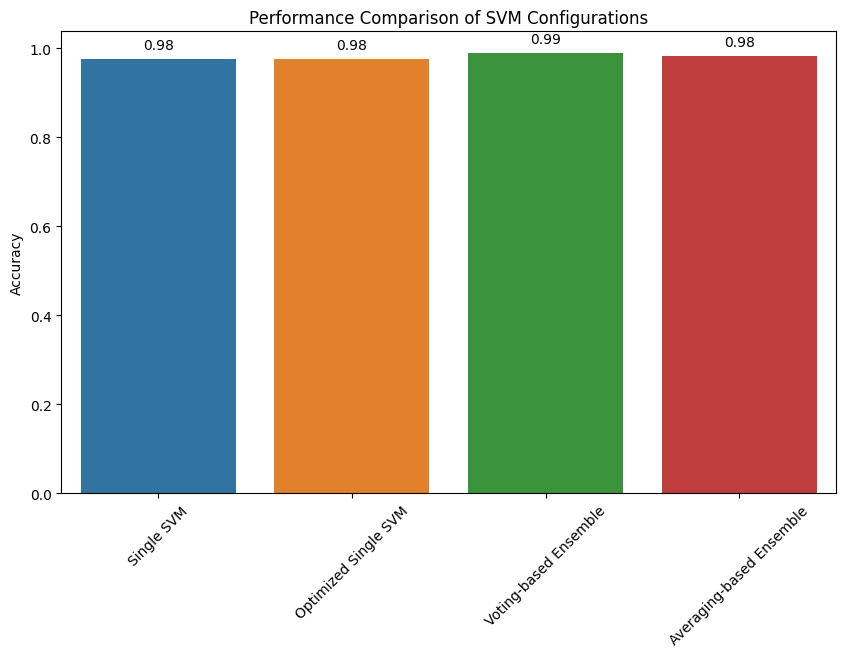

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare the performance of different SVM configurations
accuracies = [accuracy_single, accuracy_single_optimized, accuracy_voting, accuracy_avg]
names = ["Single SVM", "Optimized Single SVM", "Voting-based Ensemble", "Averaging-based Ensemble"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=names, y=accuracies)

# Annotate each bar with its respective accuracy value
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',  # this formats the value to 2 decimal places
                (p.get_x() + p.get_width() / 2., p.get_height()),  # sets the position of the text
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.title("Performance Comparison of SVM Configurations")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


In [43]:
from sklearn.metrics import classification_report, confusion_matrix

def print_metrics(y_true, y_pred, title=""):
    print(title)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {title}')
    plt.show()


Voting-based Ensemble

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       108
           1       1.00      0.97      0.98        63

    accuracy                           0.99       171
   macro avg       0.99      0.98      0.99       171
weighted avg       0.99      0.99      0.99       171


Confusion Matrix:
[[108   0]
 [  2  61]]


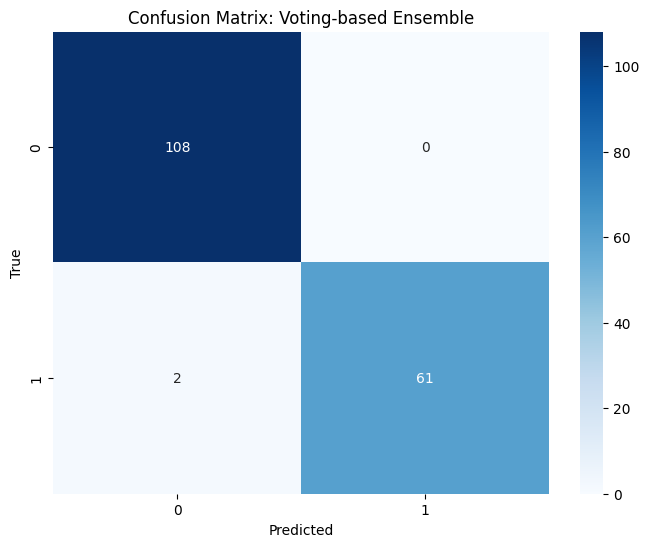

Averaging-based Ensemble

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       108
           1       0.97      0.98      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171


Confusion Matrix:
[[106   2]
 [  1  62]]


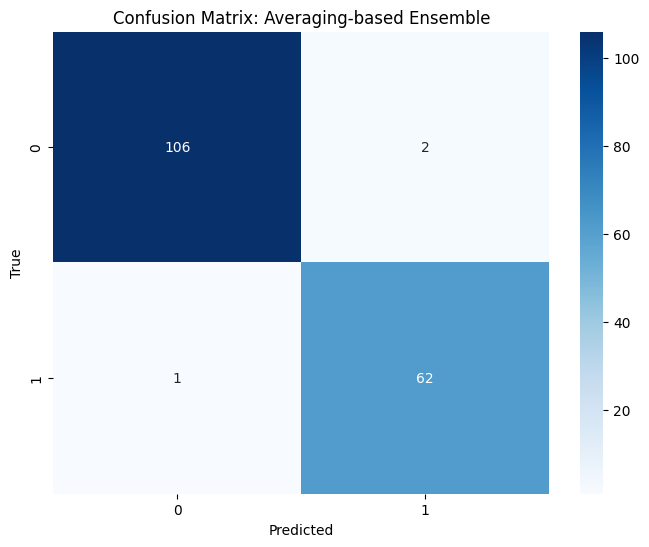

Single SVM

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       108
           1       0.97      0.97      0.97        63

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171


Confusion Matrix:
[[106   2]
 [  2  61]]


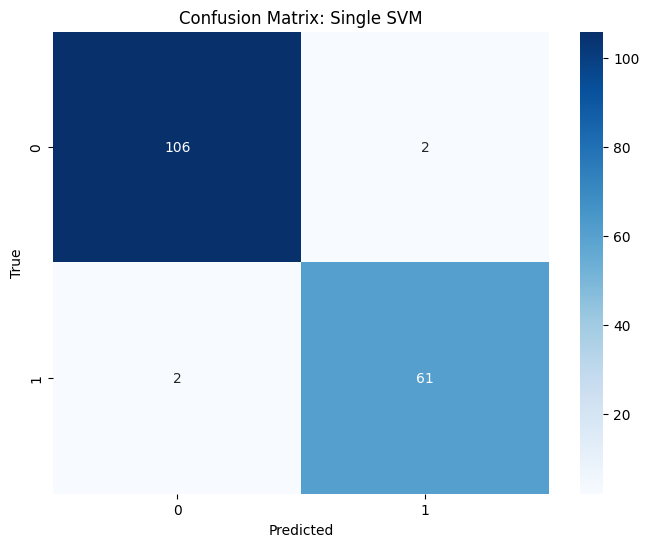

Optimized Single SVM

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       108
           1       0.97      0.97      0.97        63

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171


Confusion Matrix:
[[106   2]
 [  2  61]]


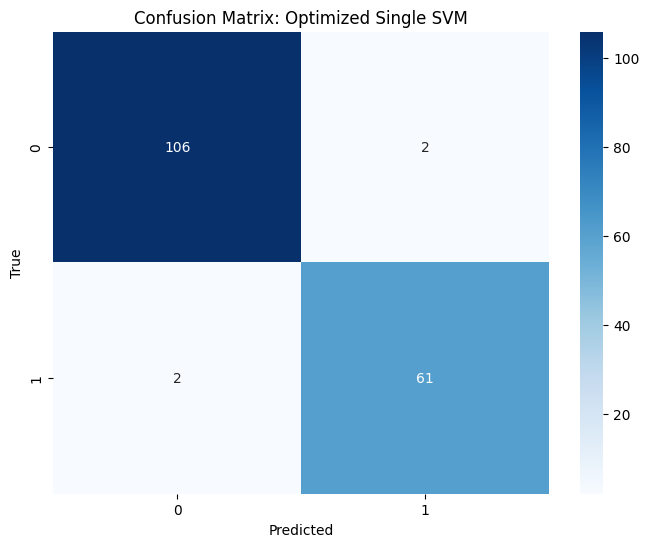

In [44]:
# For the voting-based ensemble
print_metrics(y_test, final_predictions, title="Voting-based Ensemble")

# For the averaging-based ensemble
print_metrics(y_test, avg_predictions, title="Averaging-based Ensemble")

# For single SVM
print_metrics(y_test, single_predictions, title="Single SVM")

# For optimized single SVM
print_metrics(y_test, single_predictions_optimized, title="Optimized Single SVM")


#### Flows

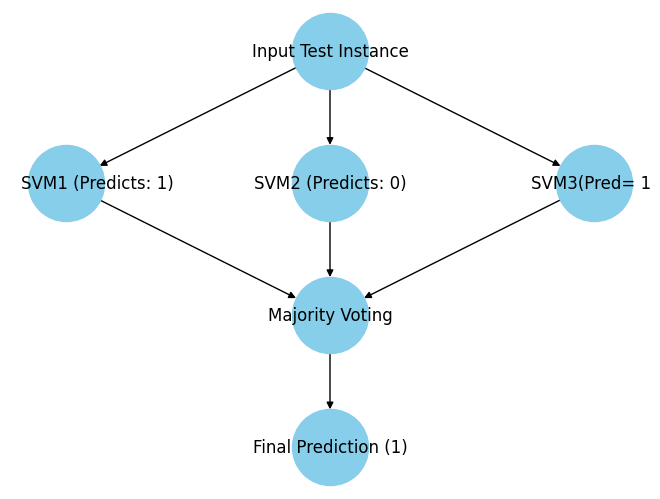

In [65]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Adding edges
G.add_edges_from([(1, 2), (1, 3), (1, 4), (2, 5), (3, 5), (4, 5), (5, 6)])

# Adjusting node positions for clarity
pos = {
    1: (0, 1),
    2: (-1, 0.5),
    3: (0, 0.5),
    4: (1, 0.5),
    5: (0, 0),
    6: (0, -0.5)
}

# Defining labels
labels = {
    1: 'Input Test Instance',
    2: '            SVM1 (Predicts: 1)',
    3: 'SVM2 (Predicts: 0)',4:'SVM3(Pred= 1)',
    5: 'Majority Voting',
    6: 'Final Prediction (1)'
}

nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color='skyblue')
plt.show()


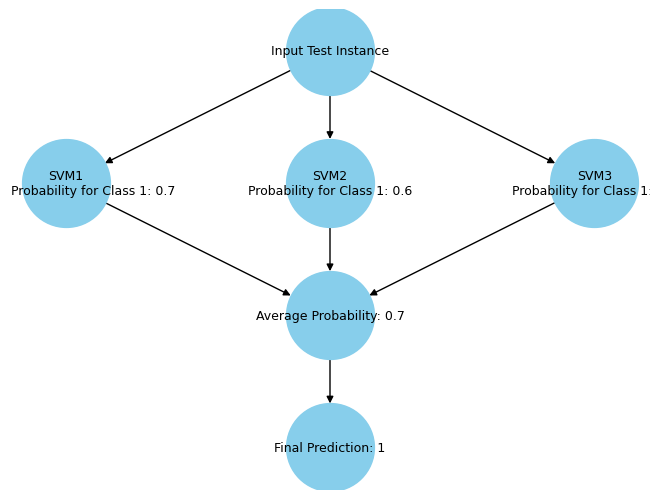

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Adding edges to the graph
G.add_edges_from([(1, 2), (1, 3), (1, 4), (2, 5), (3, 5), (4, 5), (5, 6)])

# Adjusting node positions for a better visual representation
pos = {
    1: (0, 1),
    2: (-1, 0.5),
    3: (0, 0.5),
    4: (1, 0.5),
    5: (0, 0),
    6: (0, -0.5)
}

# Defining labels for each node
labels = {
    1: 'Input Test Instance',
    2: 'SVM1\n              Probability for Class 1: 0.7',
    3: 'SVM2\nProbability for Class 1: 0.6',
    4: 'SVM3\nProbability for Class 1: 0.8',
    5: 'Average Probability: 0.7',
    6: 'Final Prediction: 1'
}

# Drawing the graph
nx.draw(G, pos, labels=labels, with_labels=True, node_size=4000, node_color='skyblue', font_size=9)
plt.show()
